In [67]:
import sys
sys.path.append('..')

import json
import matplotlib.pyplot as plt
import os
import pathlib

from src.data_loader import DataLoader
from src.pickle_loader import PickleLoader

In [68]:
# defines
random_good_model_file = "../results/v5/BLEU_scores/random_good_model_BLEU_scores.pickle"
random_good_model_file_2 = "../results/optimization/random_good_model_v2.txt"

In [69]:
def plot_txt_dict_file(path: str, print_max=False):
    if pathlib.Path(path).suffix == ".txt":
        with open(path, 'r') as f:
            results = json.load(f)
    else:
        results = PickleLoader.load(path)

    results = [
        (i, results[f'model_{i}.pt']) for i in range(20) if f'model_{i}.pt' in results
    ]

    bleus = [bleu for _, bleu in results]
    checkpoint_idx = [cp for cp, _ in results]

    if print_max:
        best_cp = max(results, key=lambda x: x[1])
        print(best_cp)
    plt.plot(checkpoint_idx, bleus, '-o')

In [70]:
def plot_files(*files, print_max=False):
    legend = []
    for name, path in files:
        plot_txt_dict_file(path, print_max)
        legend.append(name)
    plt.legend(legend)
    plt.xlabel("Checkpoint")
    plt.ylabel("BLEU")
    plt.xticks([0, 5, 10, 15, 20])
    plt.show()

# Bug Fixes
Zu Beginn haben wir erstmal einige kleine Bugs gefixt, wie etwa falsche Masken oder kleine Fehler bei der Berechnung der Attention. Dadurch konnten wir den BLEU von unserer Baseline (random_good_model) auf etwa 0.249 (Checkpoint 15) erhöhen (random_good_model_2).

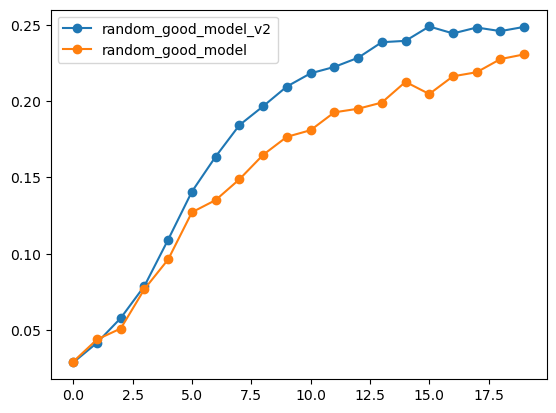

In [71]:
plot_txt_dict_file(random_good_model_file_2)
plot_txt_dict_file(random_good_model_file)

plt.legend(["random_good_model_v2", "random_good_model"])
plt.show()

Schon am Freitag haben wir dann fleißig angefangen, Parameter zu optimieren. Zunächst haben wir mit dem RNN Typ (LSTM vs GRU) angefangen, doch schon ist uns aufgefallen, dass der BLEU bereits wesentlich schlechter als von unserer Baseline "random_good_model" ist.

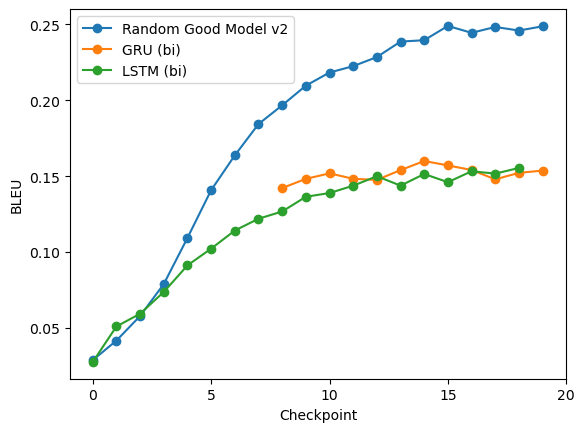

In [72]:
gru_file = "../results/optimization/rnn_type/gru_bi.txt"
lstm_file = "../results/optimization/rnn_type/lstm_bi.txt"
plot_files(("Random Good Model v2", random_good_model_file_2), ("GRU (bi)", gru_file), ("LSTM (bi)", lstm_file))

Auch nach weiteren Tests, bei denen die Anzahl der RNN Layer (1, 2, 3) getestet wurde, haben wir festgestellt, dass die Performance noch immer schlechter als die Baseline war (leider ist vom 3_Layer_Test was verloren gegangen hehe):

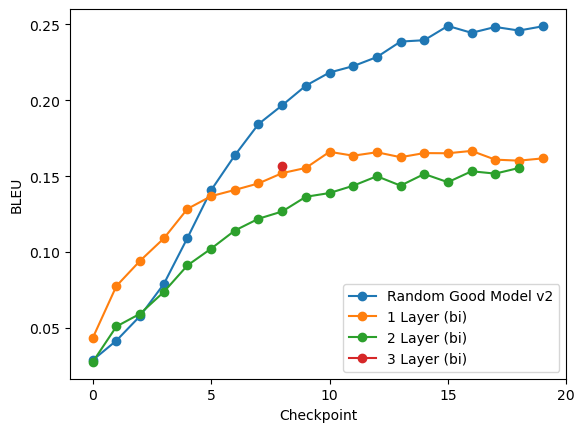

In [73]:
# BLEU Grafik 1 vs 2 vs 3
layer_1_file = "../results/optimization/amount_rnn_layers/1_layer_bi.txt"
layer_2_file = "../results/optimization/amount_rnn_layers/2_layer_bi.txt"
layer_3_file = "../results/optimization/amount_rnn_layers/3_layer_bi.txt"

plot_files(("Random Good Model v2", random_good_model_file_2), ("1 Layer (bi)", layer_1_file), ("2 Layer (bi)", layer_2_file), ("3 Layer (bi)", layer_3_file))

Wir haben uns daher auf die Suche nach dem Grund gemacht, warum alle Modelle so viel schlechter als "random_good_model war"... und herausgefunden, dass die Baseline mit einem unidirektionalen Encoder trainiert wurde! Wie kann das sein, wo doch - völlig intuitiv gesehen - ein bidirektionaler Encoder immer mindestens die gleichen Informationen wie ein unidirektionaler Encoder kodiert? 

<img src="https://i.kym-cdn.com/entries/icons/original/000/031/197/visible.jpg">

Um nicht zu viel Zeit zu verschwenden, haben wir das Problem erstmal ignoriert und fleißig weiter trainiert. Jedoch waren die Tests auch mit unidirektionalem Encoder nicht viel besser und konnten nicht an die Baseline herankommen. Schon die erneuten Tests für den RNN Type (LSTM vs GRU) haben schlechtere Performance als die Baseline gezeigt:

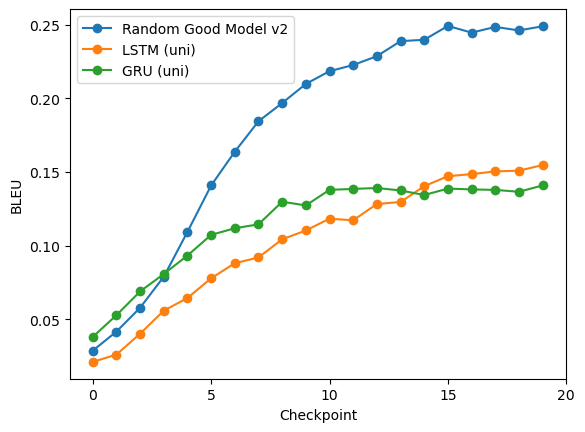

In [74]:
random_good_model_file_2 = "../results/optimization/random_good_model_v2.txt"
lstm_uni_file = "../results/optimization/rnn_type/lstm_uni.txt"
gru_uni_file = "../results/optimization/rnn_type/gru_uni.txt"

plot_files(("Random Good Model v2", random_good_model_file_2), ("LSTM (uni)", lstm_uni_file), ("GRU (uni)", gru_uni_file))

<img src="https://i.imgflip.com/7raqx9.jpg">

Berechtigerweise haben wir uns gewundert, warum selbst der unidirektionale Encoder nichts gebracht hat. Ist Random Good Model v2 etwa wie der 6er im Lotto, den wir mit der zufälligen Gewichtsinitialisierung gezogen haben? "Nein...", dachten wir uns, "so viel Glück haben wir nicht", und machten uns weiter auf die Suche. Nicht lange hat es gedauert, bis wir fest gestellt hatten, dass Random Good Model v2 einen weiteren Parameter anders als die Default Settings hatten, nämlich die Attention Function: Während Random Good Model v2 Additive Attention (Bahdanau-Paper) verwendet hatte, haben alle anderen Modelle die Dot-Product Attention (Vaswani-Paper) eingebaut. Diese scheint wohl einige Probleme zu machen, denn schon die ersten Tests mit der Additive Attention haben positive Ergebnisse gezeigt:

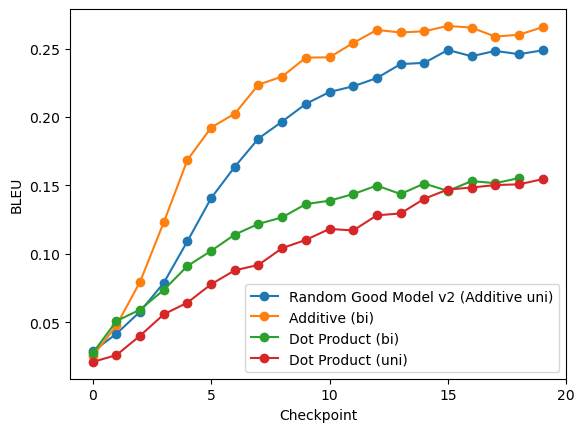

In [75]:
random_good_model_file_2 = "../results/optimization/random_good_model_v2.txt"
additive_bi_file = "../results/optimization/attention_function/additive_bi.txt"
dot_product_bi_file = "../results/optimization/attention_function/dot_product_old_bi.txt"
dot_product_uni_file = "../results/optimization/attention_function/dot_product_old_uni.txt"

plot_files(("Random Good Model v2 (Additive uni)", random_good_model_file_2), ("Additive (bi)", additive_bi_file), ("Dot Product (bi)", dot_product_bi_file), ("Dot Product (uni)", dot_product_uni_file))

Wie erwartet performt das Modell unter Verwendung der Additive Attention mit bidirektionalem Encoder wesentlich besser als mit unidirektionalem. Daher verwenden wir in allen kommenden Tests immer bidirektionale Encoder.

# Hyperparameter Tuning
Nun kann das richtige Hyperparametert Tuning endlich beginnen...

<img src="https://i.imgflip.com/7raroc.jpg"/>

### RNN Type

Zunächst einmal testen wir - wie ursprünglich geplant - verschiedene RNN Typen (GRU vs LSTM). Dabei haben wir festgestellt, dass LSTMs mit einem maximalen BLEU von 0.267 besser waren als GRUs mit einem maximalen BLEU von 0.2486. Letztere waren sogar schlechter als unsere bisherige Baseline (Random Good Modell v2), welcher LSTMs mit unidirektionalem Encoder verwendet.

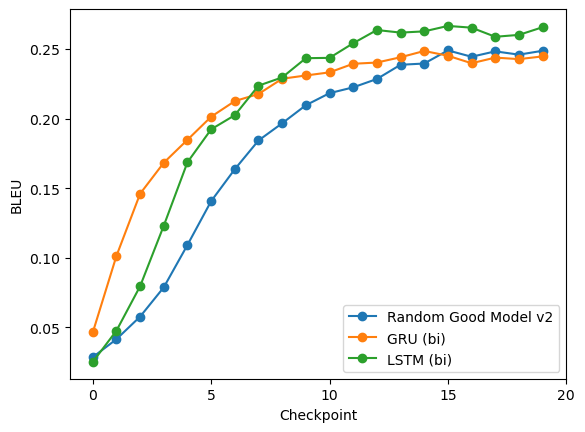

In [76]:
gru_file = "../results/optimization/rnn_type/gru_additive_bi.txt"
lstm_file = "../results/optimization/rnn_type/lstm_additive_bi.txt"

plot_files(("Random Good Model v2", random_good_model_file_2), ("GRU (bi)", gru_file), ("LSTM (bi)", lstm_file))

Wir beschränken uns daher in den nächsten Experimenten nur auf LSTMs und vergleichen auch nicht mehr mit der Baseline.

### Anzahl von RNN Layern
Als nächstes testen wir die Anzahl der RNN Layer im Encoder und Decoder. Wir beschränken uns daher zunächst, im Encoder und Decoder die gleiche Anzahlen zu testen. Die Default-Settings (etwa für random good model v2) waren 2 RNN Layers im Encoder und Decoder. Daher haben wir zunächst damit begonnen, die Anzahl auf 1 zu reduzieren, um zu untersuchen, ob unser Modell womöglich mächtiger als nötig ist. Parallel haben wir auch ein RNN mit 3 Layern getestet. Dabei war das Modell mit 1 RNN Layer (jeweils im Encoder und Decoder) den 2 RNN Layer Modell überlegen (0.291 vs 0.267). Das 3-RNN-Layer-Modell hingegen war dem 2-RNN-Layer-Modell deutlich unterlegen (0.134 vs 0.267). Wir verwenden daher in den nächsten Experimenten standardmäßig 1 RNN Layer im Modell, falls nicht anders angegeben:

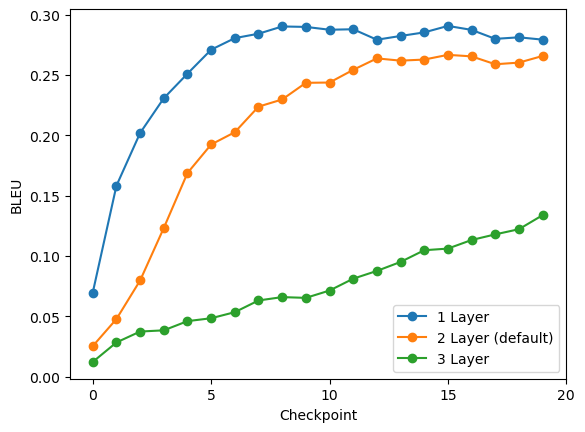

In [77]:
layer_1_file = "../results/optimization/amount_rnn_layers/1_layer_additive_bi.txt"
layer_2_file = "../results/optimization/amount_rnn_layers/2_layer_additive_bi.txt"
layer_3_file = "../results/optimization/amount_rnn_layers/3_layer_additive_bi.txt"

plot_files(("1 Layer", layer_1_file), ("2 Layer (default)", layer_2_file), ("3 Layer", layer_3_file))

### Filler Episode: Dot-Product Fix

Doch warum hat die Dot-Product Attention bei eigentlich uns so schlecht performt, wo doch in der Praxis diese sehr häufig über der Additive Attention verwendet wird (s. etwa Vaswani et al.)? Nach etwas Recherche und Vergleich mit relevanten Papern haben wir festgestellt, dass die Energys mit einem Faktor $\frac{1}{\sqrt{d}}$, wobei $d$ die Größe des Hidden Layers ist. Nachdem wir dies angepasst haben, hat die Dot-Product Attention bereits wesentlich besser performt als zuvor:

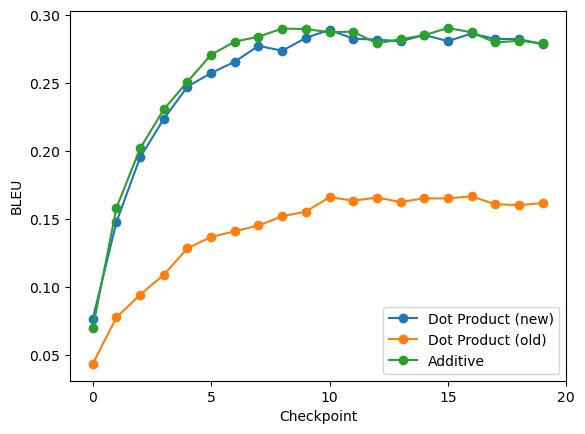

In [78]:
dot_product_new_file = "../results/optimization/attention_function/dot_product_bi_fixed_1_layer.txt"
dot_product_old_file = "../results/optimization/amount_rnn_layers/1_layer_bi.txt"
additive_file = "../results/optimization/amount_rnn_layers/1_layer_additive_bi.txt"

plot_files(("Dot Product (new)", dot_product_new_file), ("Dot Product (old)", dot_product_old_file), ("Additive", additive_file))

Damit performt die Dot-Product Attention nun sehr ähnlich zur Additive Attention. Da die Additive Attention in diesem Experiment jedoch minimal höher war - sei es aus Zufall oder wegen der Natur der Funktion -, verwenden wir in den weiteren Experimenten standardmäßig die Additive Attention, falls nicht anders angegeben.

<a><img src="https://i.imgflip.com/7s55hi.jpg"/></a>

### Verschiedene RNN Layer Anzahlen
Neben dem Test von gleichen Anzahl an RNN Layern im Encoder und Decoder haben wir - wie auf den Folien vorgeschlagen - getestet, den Decoder mit mehr Layern (2) als im Encoder (1) auszustatten. Dabei haben wir noch die (gefixte) Dot-Product-Attention verwendet. Da aber, wie bereits gezeigt, sich Dot-Product Attention und Additive Attention nicht viel nehmen, sind mögliche Unterschiede vernachlässigbar.Die Ergebnisse sind die folgenden:

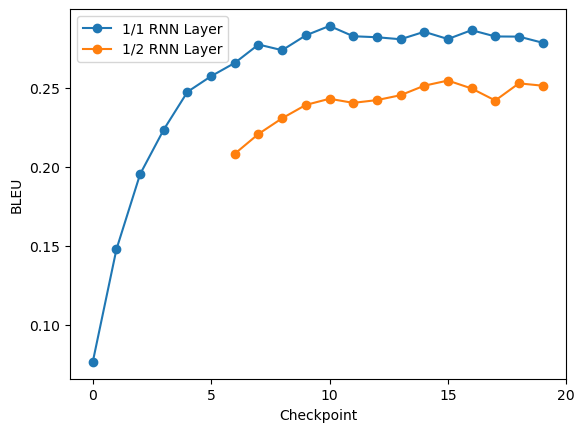

In [79]:
layer_1_1_file = "../results/optimization/attention_function/dot_product_bi_fixed_1_layer.txt"
layer_1_2_file = "../results/optimization/amount_rnn_layers/1_layer_enc_2_layer_dec.txt"

plot_files(   
    ("1/1 RNN Layer", layer_1_1_file),
    ("1/2 RNN Layer", layer_1_2_file),
)

Wir erkennen, dass die Konfiguration 1/2 RNN Layers schlechter performt als die Konfiguration 1/1 (und tatsächlich näher an der 2/2 Konfiguration ist). Wir belassen die RNN Layers in den zukünftigen Experimenten daher bei einer 1/1-Konfiguration.

### Embedding Dimension

Als nächstes haben wir uns an die Größen der Layer gesetzt und mit den Embedding Layern angefangen. Der Default war eine Embedding Layer Size von 100/100 im Encoder/Decoder. Aus analogen Gründen wie beim Test der Anzahl von RNN Layern beschränken wir uns im Encoder und Decoder auf die gleiche Embedding Size. Wir haben sowohl eine kleinere Embedding Size als auch größere getestet. Die Ergebnisse sind wie folgt:

(11, 0.26823706859080493)
(15, 0.2905997827254083)
(11, 0.2965348994657374)
(9, 0.3037700867571395)
(8, 0.29292402276373625)
(18, 0.2788100223839707)


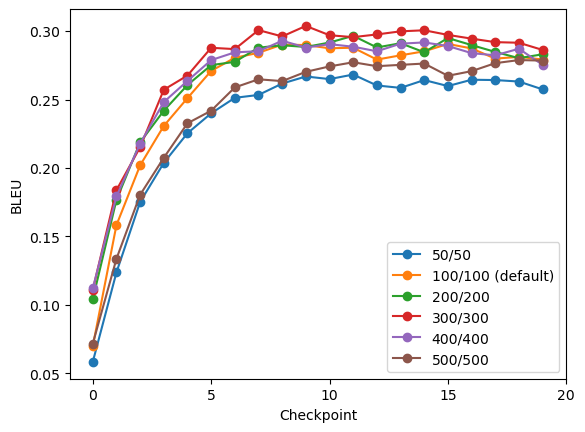

In [80]:
embedding_50_50_file = "../results/optimization/embedding_dim_test/embedding_50_50.txt"
embedding_100_100_file = "../results/optimization/embedding_dim_test/embedding_100_100.txt"
embedding_200_200_file = "../results/optimization/embedding_dim_test/embedding_200_200.txt"
embedding_300_300_file = "../results/optimization/embedding_dim_test/embedding_300_300.txt"
embedding_400_400_file = "../results/optimization/embedding_dim_test/embedding_400_400.txt"
embedding_500_500_file = "../results/optimization/embedding_dim_test/embedding_500_500.txt"

plot_files(("50/50", embedding_50_50_file), ("100/100 (default)", embedding_100_100_file), ("200/200", embedding_200_200_file), ("300/300", embedding_300_300_file), ("400/400", embedding_400_400_file),("500/500", embedding_500_500_file), print_max=True)

Den besten BLEU-Wert von rund 30.38 haben wir mit einem Embedding Layer der Größe 300/300 erreicht. Wir passen daher für zukünftige Experimente - solange nicht anders erwähnt - die Embedding Layer Größe auf 300/300 an.

## Gradient Clipping
<img src="../results/pictures/gradient_clipping.png" style="width:70%;">

Parallel zum Test der Embedding-Sizes haben wir mit Gradient Clipping experimentiert (d.h. noch mit der alten Embedding Size von 100). Der Default Clipping Value lag bisher immer bei 1. Da Gradient Clipping einen großen Einfluss auf das Exploding Gradient Problem bei RNNs und damit auch auf die Konvergenz hat, wollten wir sowohl geringere als auch größere Werte zum Clippen testen. Daher haben wir die Werte 0.5, 1 (default) und 3 zunächst getestet mit folgenden Ergebnissen:

(15, 0.28481038398674696)
(15, 0.2905997827254083)
(15, 0.2910703973766425)


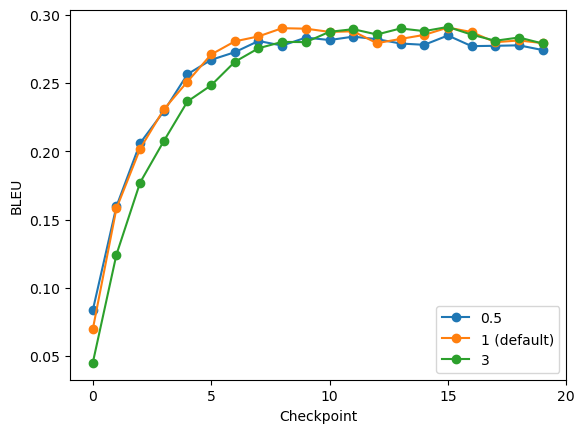

In [85]:
clip_0_5_file = "../results/optimization/gradient_clipping/clipping_0_5.txt"
clip_1_file = "../results/optimization/gradient_clipping/clipping_1.txt"
clip_3_file = "../results/optimization/gradient_clipping/clipping_3.txt"

plot_files(("0.5", clip_0_5_file), ("1 (default)", clip_1_file), ("3", clip_3_file), print_max=True)

Interessanterweise sind die Ergebnisse bei den drei verschiedenen Clipping Values sehr ähnlich zueinander - wir interpretieren das so, dass unser Modell scheinbar kaum Probleme mit Exploding Gradients hat. Da die Werte so ähnlich zueinander sind und wir zukünftige Experimente bereits mit einem Gradient Clipping mit Value 1 durchgeführt haben, belassen wir das bei diesem Default Wert.

### Hidden dimension
Als nächstes haben wir die Größe des Hidden Layers getestet. Standardmäßig war diese sowohl im Encoder als auch im Decoder auf 200. Wir haben nun sowohl eine Größe von 100 als auch von 300 getestet mit den folgenden Ergebnissen:

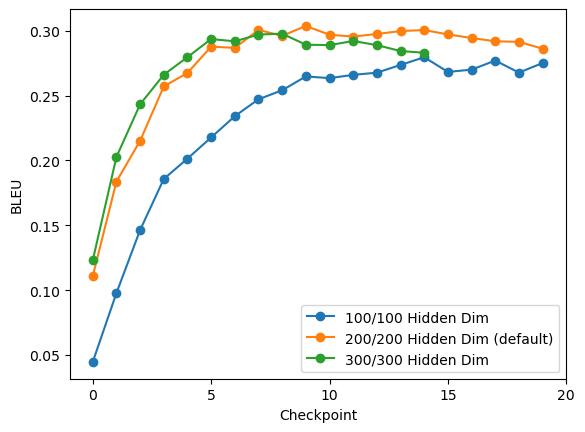

In [ ]:
hidden_100_100_file = "../results/optimization/hidden_dim_test/hidden_100_100.txt"
hidden_200_200_file = "../results/optimization/hidden_dim_test/hidden_200_200.txt"
hidden_300_300_file = "../results/optimization/hidden_dim_test/hidden_300_300.txt"

plot_files(("100/100 Hidden Dim", hidden_100_100_file), ("200/200 Hidden Dim (default)", hidden_200_200_file), ("300/300 Hidden Dim", hidden_300_300_file))

Wie zu sehen, hat die Default Hidden Size von 200/200 bereits die beste Performance gezeigt - wir belassen es daher bei dieser. 

### Teacher Forcing

Zusätzlich haben wir teacher forcing mit Werten in [0,1], sowie unterschiedlichem Verfall (decay) getestet. Einmal 0 , 0.5 und 1 jeweils mit konstantem Verfall und zudem sowohl 0.5 mit linearem Verfall, als auch 1 mit exponentiellem Verfall. 

<img src="../results/pictures/teacher_forcing.jpeg" style="width:50%;">

Unsere Experimente haben wir nun mit dem Test von Teacher Forcing fortgeführt. Standardmäßig hatten wir bisher einen Wert von 0.5 verwendet gehabt. Nun hat es uns noch interessiert, wie das Modell konvergiert wenn immer die eigenen Predictions im Decoder verwendet werden (Teacher Forcing von 0) oder wenn es immer die korrekten Predictions erhält (Teacher Forcing von 0). Außerdem haben wir auch mit dynamischen Teacher Forcing Ratios experimentiert. Unsere Vermutung war nämlich, dass Teacher Forcing am Anfang vom Training, wo das Modell noch sehr inkompetent ist, einen positiven Einfluss hat, am Ende des Trainings jedoch dazu führt, dass das Modell nicht lernt eigenständig ganze Sätze zu übersetzen. Wir haben daher linearen und exponentiellen Abfall getestet. Dabei haben wir die Teacher Forcing Ratio in der $i$-ten Epoche wie folgt bestimmt:

$$\text{tf}_{i,\exp} = \text{tf}_0 * \exp(-i)$$
$$\text{tf}_{i,\text{lin}} = \text{tf}_0 * (1 - \frac{i}{n_\text{epochs}})$$

$\text{tf}_0$ konnte dabei frei gewählt werden und entspricht der initialen Teacher Forcing Ratio, von der aus dann der Abfall berechnet wird. 

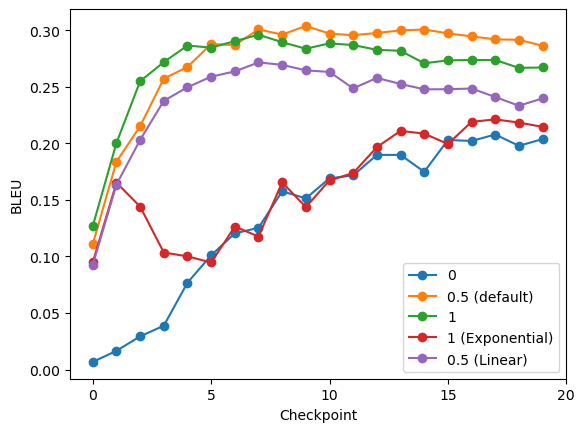

In [ ]:
teacher_0_file = "../results/optimization/teacher_forcing/teacher_0.txt"
teacher_0_5_file = "../results/optimization/teacher_forcing/teacher_0_5.txt"
teacher_1_file = "../results/optimization/teacher_forcing/teacher_1.txt"
teacher_1_exponential = "../results/optimization/teacher_forcing/teacher_1_exponential.txt"
teacher_0_5_linear = "../results/optimization/teacher_forcing/teacher_0_5_linear.txt"

plot_files(("0", teacher_0_file), ("0.5 (default)", teacher_0_5_file), ("1", teacher_1_file), ("1 (Exponential)", teacher_1_exponential), ("0.5 (Linear)", teacher_0_5_linear))

Wir erkennen, dass der bisherige Default-Wert von 0.5 scheinbar die besten Ergebnisse liefert. Wie vermutet, liefert die Verwendung von keinem Teacher Forcing zu einer verhältnismäßig langsamen Konvergenz. Überraschenderweise haben wir mit der Verwendung von 100% Teacher Forcing dennoch eine solide Performance erreicht - scheinbar lernt das Modell also trotz des Teacher Forcings, Sätze einigermaßen eigenständig zu übersetzen.

Zu unserer Überraschung waren beide TF Scheduling Methoden äußerst schwach. Besonders exponentieller Abfall hat zu sehr sprunghaften BLEUs geführt, was wir zu nicht erwartet hatten.

Wir bleiben daher beim Default Wert von 0.5.

### Layer Norm

<a><img src="https://i.imgflip.com/7sba9l.jpg"/></a>

Weiterhin haben wir noch die Verwendung von Layer Norm getestet. Sowohl im Encoder als auch im Decoder haben wir dabei LayerNorm nach dem Embedding und nach dem RNN Layer verwendet:

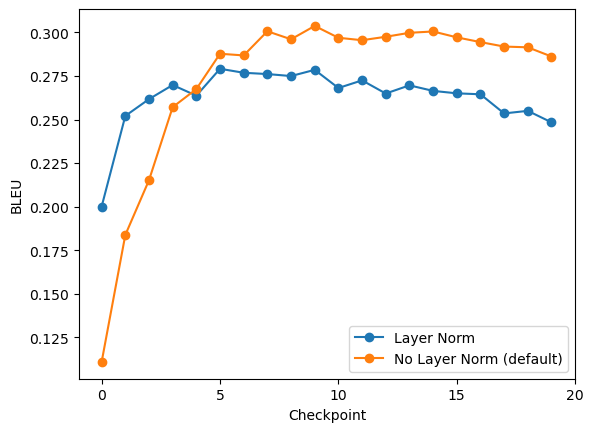

In [ ]:
layer_norm_file = "../results/optimization/layer_norm_test/layer_norm.txt"
no_layer_norm_file = "../results/optimization/layer_norm_test/no_layer_norm.txt"

plot_files(("Layer Norm", layer_norm_file), ("No Layer Norm (default)", no_layer_norm_file))

Auch wenn LayerNorm zu Beginn wesentlich besser konvergiert hatte als ohne LayerNorm, hat sich der Spieß im späteren Trainigsverlauf gedreht, sodass ohne LayerNorm das Modell besser war. Wir belassen es daher, unser Modell ohne LayerNorm zu verwenden.

### Batch Size

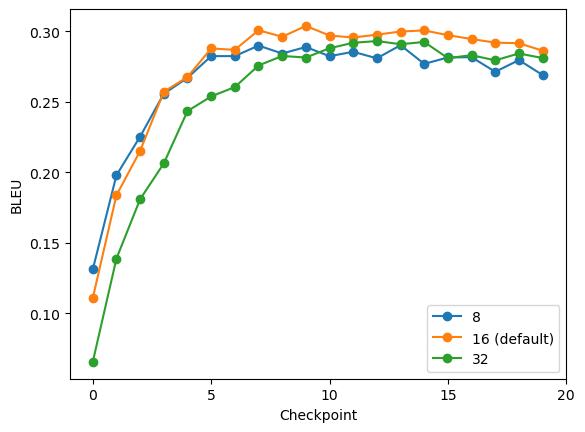

In [ ]:
batch_size_8_file = "../results/optimization/batch_size_test/batch_size_8.txt"
batch_size_16_file = "../results/optimization/batch_size_test/batch_size_16.txt"
batch_size_32_file = "../results/optimization/batch_size_test/batch_size_32.txt"

plot_files(("8", batch_size_8_file), ("16 (default)", batch_size_16_file), ("32", batch_size_32_file))

### Dropout
<a><img src="https://i.imgflip.com/7s545u.jpg"/></a><

Weiterhin haben wir mit Dropout experimentiert. Im Encoder haben wir den Dropout Layer hinter dem Embedding Layer platziert, im Decoder hinter den RNN Layer. Bisher haben wir keinen Dropout (0.0) standardmäßig verwendet. In der Literatur werden Werte bis zu 0.5 verwendet, wir haben daher Dropouts von 0.1, 0.2, 0.3, 0.4 und 0.5 getestet:

(19, 0.26500788088896865)
(18, 0.2958540109750125)
(19, 0.29933724127746053)
(18, 0.3077163907608669)
(13, 0.30571329919453405)
(9, 0.3037700867571395)


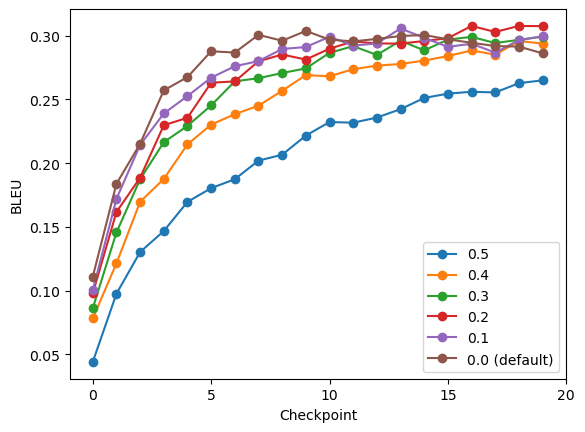

In [ ]:
dropout_0_5_file = "../results/optimization/dropout_test/dropout_0_5.txt"
dropout_0_4_file = "../results/optimization/dropout_test/dropout_0_4.txt"
dropout_0_3_file = "../results/optimization/dropout_test/dropout_0_3.txt"
dropout_0_2_file = "../results/optimization/dropout_test/dropout_0_2.txt"
dropout_0_1_file = "../results/optimization/dropout_test/dropout_0_1.txt"
dropout_0_file = "../results/optimization/dropout_test/dropout_0.txt"

plot_files(("0.5", dropout_0_5_file), ("0.4", dropout_0_4_file), ("0.3", dropout_0_3_file), ("0.2", dropout_0_2_file), ("0.1", dropout_0_1_file), ("0.0 (default)", dropout_0_file), print_max=True)

Mit einem Dropout von 0.2 hatten wir den maximalen BLEU von 30.77 erreicht. Wir verwenden daher auch diesen Dropout in den zukünftigen Experimenten.

### BPE Operations

Zum Schluss haben wir noch die Anzahl an BPE Operationen für das Modell getestet. Wir hatten bereits BPE Encoder und Dictionaries für 1000, 3000, 5000, 7000 (default), 10000, 12000 und 15000 vortrainiert. Daher haben wir unsere Experimente auch erstmal auf diese Werte beschränkt (unjoined) mit folgenden Ergebnissen:

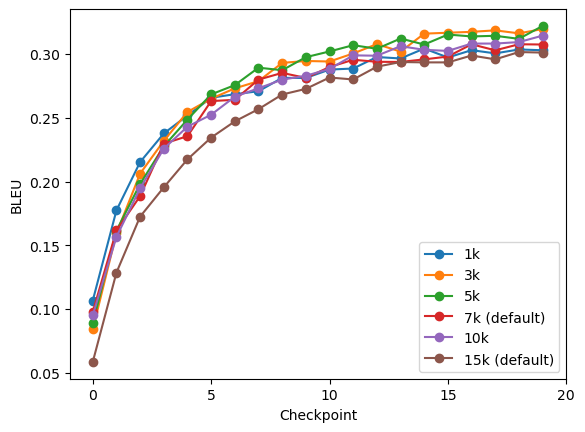

In [87]:
bpe_1k_file = "../results/optimization/bpe_size_test/1k_bpe.txt"
bpe_3k_file = "../results/optimization/bpe_size_test/3k_bpe.txt"
bpe_5k_file = "../results/optimization/bpe_size_test/5k_bpe.txt"
bpe_7k_file = "../results/optimization/bpe_size_test/7k_bpe.txt"
bpe_10k_file = "../results/optimization/bpe_size_test/10k_bpe.txt"
#bpe_12k_file = "../results/optimization/bpe_size_test/12k_bpe.txt"
bpe_15k_file = "../results/optimization/bpe_size_test/15k_bpe.txt"

#plot_files(("1k", bpe_1k_file), ("3k", bpe_3k_file), ("5k", bpe_5k_file), ("7k (default)", bpe_7k_file), ("10k", bpe_10k_file), ("12k", bpe_12k_file), ("15k (default)", bpe_15k_file))
plot_files(("1k", bpe_1k_file), ("3k", bpe_3k_file), ("5k", bpe_5k_file), ("7k (default)", bpe_7k_file), ("10k", bpe_10k_file), ("15k (default)", bpe_15k_file))